# Papers Past Genre Classification
# Notebook 10: Binary Classification - Family Notice - Logistic Regression
---

This notebook trains and a binary classification model for the genre Family Notice in the Papers Past open data using the 'all_features' feature set. The predictions and prediction probabilities are returned in a dataframe. 


In [1]:
import pandas as pd
import numpy as np
import pickle

# Features
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.linear_model import LogisticRegression

# Metrics/Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from datetime import date
from datetime import datetime

In [2]:
filepath = '20220113_PP_3518articles_withfeatures.pkl'
features_df = pd.read_pickle(filepath)

In [3]:
len(features_df)

3518

In [4]:
# View the distribution of the genres
(features_df['genre'].value_counts() / len(features_df)).sort_values(ascending=False)

Report            0.284537
News              0.163729
Notice            0.162308
Opinion           0.138999
Feature           0.048891
LetterToEditor    0.047754
Results           0.041217
FamilyNotice      0.029278
Fiction           0.020182
Advertisement     0.018761
Review            0.018476
Poetry            0.009665
Obituary          0.009096
Speech            0.007106
Name: genre, dtype: float64

In [5]:
# Adding a feature to identify keywords in the title that are specific to this genre

features_df["title_keyword"] = 0
features_df.loc[features_df.title.str.contains("MARRI|DEATH|BIRTH|Marri|Death|Birth|DIED|Died|Obituary|OBITUARY|FUNERAL|funeral|Memori|MEMORI"), "title_keyword"] = 1

In [6]:
# Genre to classify
genre = "FamilyNotice"

# List of features
features = ["propn_freq", 
            "verb_freq", 
            "noun_freq", 
            "adj_freq", 
            "nums_freq", 
            "pron_freq", 
            "nnps_freq", 
            "vb_freq", 
            "nn_freq", 
            "jj_freq", 
            "cd_freq", 
            "prp_freq", 
            "rb_freq", 
            "cc_freq", 
            "nnp_freq", 
            "vbd_freq", 
            "vbz_freq", 
            "stopword_freq", 
            "avg_line_offset", 
            "max_line_offset", 
            "avg_line_width", 
            "min_line_width", 
            "max_line_width", 
            "line_width_range", 
            "polysyll_freq", 
            "monosyll_freq", 
            "sentence_count", 
            "word_count", 
            "avg_word_length", 
            "char_count", 
            "tf_idf_sum", 
            "title_keyword", 
            "binary_class"]

In [7]:
# Preliminary model evaluation using default parameters
# Code reference: https://medium.com/@robert.salgado/multiclass-text-classification-from-start-to-finish-f616a8642538

# Function to get the scores for each model in a df
def model_score_df(X_train, X_test, y_train, y_test):
    """
    Train a logistic regression model to classify a family notice.
    """
    pipe = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(class_weight="balanced",  max_iter=200))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy_result = accuracy_score(y_test, y_pred)
    precision_result = precision_score(y_test, y_pred, average = 'binary')
    recall_result = recall_score(y_test, y_pred, average = 'binary')
    f1_result = f1_score(y_test, y_pred, average = 'binary')
    auroc_result = roc_auc_score(y_test, y_pred)

    print("-----------------------------------------------")
    print(f"Binary Classification - Logistic Regression")
    print(f"Genre = Family Notice")
    print("-----------------------------------------------")
    print()
    print(f"Accuracy = {accuracy_result:.3f}")
    print(f"Precision = {precision_result:.3f}")
    print(f"Recall = {recall_result:.3f}")
    print(f"F1 Score = {f1_result:.3f}")
    print(f"AUROC Score = {auroc_result:.3f}")
    
    RocCurveDisplay.from_predictions(y_test, y_pred)
    plt.title("AUROC: Logistic Regression")
    plt.show()
    
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)
    
    y_prob_train = pipe.predict_proba(X_train)
    y_prob_test = pipe.predict_proba(X_test)
    
    # Get coefficients and convert from log odds to odds
    # https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1
    odds = np.exp(pipe.named_steps['clf'].coef_[0])
    
    # Save the final model
    # https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
    filename = 'pp_logistic_reg_familynotice.sav'
    pickle.dump(pipe, open(filename, 'wb'))
    
    return y_pred_train, y_pred_test, y_prob_train, y_prob_test, odds

In [8]:
def genres_binary(df, genre, features):
    """
    Create train/test split, train the model, and return the dataframe
    with appended predictions.
    """

    df['binary_class'] = np.where(df['genre']== genre, 1, 0)
    model_df = df.filter(features, axis=1)
    indices = df.index.values

    # Extract the explanatory variables in X and the target variable in y
    y = model_df.binary_class.copy()
    X = model_df.drop(["binary_class"], axis=1)

    # Train test split with stratified sampling for evaluation
    
    # Use the indices to save the order of the split.
    # https://stackoverflow.com/questions/48947194/add-randomforestclassifier-predict-proba-results-to-original-dataframe
    X_train, X_test, indices_train, indices_test = train_test_split(X, 
                                                        indices, 
                                                        test_size = .3, 
                                                        shuffle = True, 
                                                        stratify = y, 
                                                        random_state = 3)
    
    y_train, y_test = y[indices_train], y[indices_test]
    
    y_pred_train, y_pred_test, y_prob_train, y_prob_test, odds = model_score_df(X_train, X_test, y_train, y_test)

    # Add the predictions to a copy of the original dataframe
    df_new = df.copy()
    df_new.loc[indices_train,'pred_train'] = y_pred_train
    df_new.loc[indices_test,'pred_test'] = y_pred_test
    df_new.loc[indices_train,'prob_0_train'] = y_prob_train[:,0]
    df_new.loc[indices_test,'prob_0_test'] = y_prob_test[:,0]
    df_new.loc[indices_train,'prob_1_train'] = y_prob_train[:,1]
    df_new.loc[indices_test,'prob_1_test'] = y_prob_test[:,1]
    
    odds_df = pd.DataFrame(odds, X_train.columns, columns=['coef']).sort_values(by='coef', ascending=False)
    odds_df['feature'] = odds_df.index
    
    return df_new, odds_df


-----------------------------------------------
Binary Classification - Logistic Regression
Genre = Family Notice
-----------------------------------------------

Accuracy = 0.992
Precision = 0.829
Recall = 0.935
F1 Score = 0.879
AUROC Score = 0.965


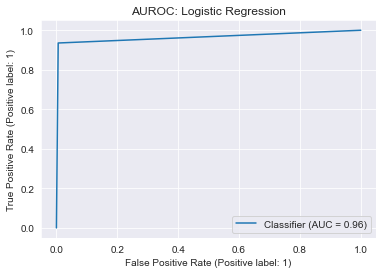

In [9]:
preds_df, odds_df = genres_binary(features_df, genre, features)

In [10]:
pd.set_option('display.max_columns', None)
preds_df

,date,newspaper_id,newspaper,article_id,avg_line_width,min_line_width,max_line_width,line_width_range,avg_line_offset,max_line_offset,min_line_offset,title,text,genre,sentence_count,clean_text,word_count,syll_count,polysyll_count,monosyll_count,stopwords_count,avg_word_length,char_count,propn_count,verb_count,noun_count,adj_count,nums_count,pron_count,nnps_count,vb_count,nn_count,jj_count,cd_count,prp_count,rb_count,cc_count,nnp_count,vbd_count,vbz_count,propn_freq,verb_freq,noun_freq,adj_freq,nums_freq,pron_freq,nnps_freq,vb_freq,nn_freq,jj_freq,cd_freq,prp_freq,rb_freq,cc_freq,nnp_freq,vbd_freq,vbz_freq,polysyll_freq,monosyll_freq,stopword_freq,tf_idf,tf_idf_sum,title_keyword,binary_class,pred_train,pred_test,prob_0_train,prob_0_test,prob_1_train,prob_1_test
0,1878-10-26,KUMAT,Kumara Times,1,452.272727,282.0,512.0,230.0,33.090909,174.0,0.0,MAILS CLOSE,"For the United Kingdom, Continent of Europe, a...",Notice,3,For the United Kingdom Continent of Europe and...,57,87,7,35,15,4.620690,325,25,4,7,1,3,0,2,2,5,1,3,0,1,3,23,0,0,0.438596,0.070175,0.122807,0.017544,0.052632,0.000000,0.035088,0.035088,0.087719,0.017544,0.052632,0.000000,0.017544,0.052632,0.403509,0.000000,0.000000,0.122807,0.614035,0.263158,"{'30p': 0.2663854421079567, 'cisco': 0.2266298...",1.124314,0,0,0.0,NaN,0.999994,NaN,6.053881e-06,NaN
1,1878-10-26,KUMAT,Kumara Times,3,429.500000,95.0,515.0,420.0,22.000000,104.0,0.0,LATEST TELEGRAMS.,": [PRESS AGENCY.] i : ;; BtUPP, October 25. / ...",FamilyNotice,5,PRESS AGENCY i BtUPP October 25 Arrived Stella...,46,72,5,30,10,4.098039,259,17,3,11,2,2,1,0,0,11,2,2,1,1,0,17,2,2,0.369565,0.065217,0.239130,0.043478,0.043478,0.021739,0.000000,0.000000,0.239130,0.043478,0.043478,0.021739,0.021739,0.000000,0.369565,0.043478,0.043478,0.108696,0.652174,0.217391,"{'bails': 0.2553070426931307, 'westpobt': 0.27...",1.328593,0,1,NaN,0.0,NaN,0.999974,NaN,2.621861e-05
2,1878-10-26,KUMAT,Kumara Times,4,469.765854,64.0,589.0,525.0,22.575610,378.0,0.0,GENERAL ASSEMBLY.,Continued from 4th page. [press agency.] .;-•'...,Report,32,Continued from 4th page press agency - J LEGIS...,1131,1628,104,794,337,4.469317,6327,332,129,215,42,34,21,7,42,168,39,34,19,14,22,326,51,6,0.293546,0.114058,0.190097,0.037135,0.030062,0.018568,0.006189,0.037135,0.148541,0.034483,0.030062,0.016799,0.012378,0.019452,0.288240,0.045093,0.005305,0.091954,0.702034,0.297966,"{'to': 0.20579354224228943, 'the': 0.440539728...",1.133181,0,0,0.0,NaN,1.000000,NaN,3.666910e-08,NaN
3,1878-10-26,KUMAT,Kumara Times,5,480.044444,109.0,599.0,490.0,18.183333,244.0,0.0,ADDITIONAL NEWS BY THE SAN FRANCISCO MAIL.,■ f > • ; •* .■<■ j.f> '■' EUROPEAN ;/ ■ LoNi>...,News,42,f j f EUROPEAN LoNi oii Septemb r 30i v - In C...,1079,1576,103,744,370,4.538462,6119,264,119,206,58,28,33,6,12,159,57,28,18,17,37,259,50,27,0.244671,0.110287,0.190918,0.053753,0.025950,0.030584,0.005561,0.011121,0.147359,0.052827,0.025950,0.016682,0.015755,0.034291,0.240037,0.046339,0.025023,0.095459,0.689527,0.342910,"{'the': 0.3078061382699132, 'of': 0.2239935499...",1.048271,0,0,0.0,NaN,1.000000,NaN,8.132614e-09,NaN
4,1878-10-26,KUMAT,Kumara Times,6,461.769231,51.0,531.0,480.0,22.745562,363.0,0.0,GENERAL ASSEMBLY.,'pPKSSS AGENCY.] LEGISLATIVE COUNCIL. Wellingt...,Report,39,pPKSSS AGENCY LEGISLATIVE COUNCIL Wellington O...,1043,1518,115,711,373,4.614573,5855,256,130,170,44,26,29,9,42,128,44,26,25,13,23,247,54,2,0.245446,0.124640,0.162991,0.042186,0.024928,0.027804,0.008629,0.040268,0.122723,0.042186,0.024928,0.023969,0.012464,0.022052,0.236817,0.051774,0.001918,0.110259,0.681687,0.357622,"{'to': 0.24361741360382583, 'bill': 0.28737846...",1.377992,0,0,0.0,NaN,1.000000,NaN,2.009893e-07,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3513,1858-10-15,DSC,Daily Southern Cross,8,587.000000,

In [11]:
final_df = preds_df.filter(["date", 
                            "newspaper_id", 
                            "newspaper", 
                            "article_id", 
                            "title", 
                            "text", 
                            "genre", 
                            "binary_class", 
                            "pred_train", 
                            "pred_test", 
                            "prob_0_train", 
                            "prob_0_test", 
                            "prob_1_train", 
                            "prob_1_test"], 
                           axis=1)
final_df["newspaper_web"] = final_df["date"].astype('string')
final_df["newspaper_web"] = final_df["newspaper_web"].str.replace('-','/')
final_df["newspaper_web"] = "https://paperspast.natlib.govt.nz/newspapers/" \
                            + final_df["newspaper"].str.replace(' ','-').str.lower().str.replace("'", "").str.replace(".", "") \
                            + "/" \
                            + final_df["newspaper_web"]

In [12]:
# This line of code will provide a dataframe with only family notices included
# final_df = final_df[final_df["genre"] == "FamilyNotice"].sort_values(by="prob_1", ascending=False)

# This line of code will provide a dataframe with all articles - ranked by probability of being the given genre
final_df = final_df.sort_values(by="prob_1_test", ascending=False)

In [13]:
final_df 

,date,newspaper_id,newspaper,article_id,title,text,genre,binary_class,pred_train,pred_test,prob_0_train,prob_0_test,prob_1_train,prob_1_test,newspaper_web
201,1876-03-13,WCT,West Coast Times,2,BIRTH.,"Eeetes. — Qn the 9th March, at Ahaura, the wif...",FamilyNotice,1,NaN,1.0,NaN,7.772031e-07,NaN,0.999999,https://paperspast.natlib.govt.nz/newspapers/w...
2107,1881-03-19,GLOBE,Globe,4,BIRTH.,"Nathan. —On March 17th, tho wife of L. E. Nath...",FamilyNotice,1,NaN,1.0,NaN,1.032672e-06,NaN,0.999999,https://paperspast.natlib.govt.nz/newspapers/g...
1838,1869-06-03,WEST,Westport Times,4,DIED.,"At North East Valley, Dunedin, on the 10th ult...",FamilyNotice,1,NaN,1.0,NaN,3.281995e-06,NaN,0.999997,https://paperspast.natlib.govt.nz/newspapers/w...
2659,1888-09-07,MEX,Marlborough Express,4,MARRIAGE.,"Stewart— Hatton.— On the 6th inst;, at the res...",FamilyNotice,1,NaN,1.0,NaN,3.794964e-06,NaN,0.999996,https://paperspast.natlib.govt.nz/newspapers/m...
2408,1886-10-19,ESD,Evening Star,5,Birth.,"Hill.—On Octobor 19, the wlfo ot Mr James Hill...",FamilyNotice,1,NaN,1.0,NaN,3.817848e-06,NaN,0.999996,https://paperspast.natlib.govt.nz/newspapers/e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512,1858-10-15,DSC,Daily Southern Cross,6,POST OFFICE.,"Mails close — For Tlussell, per St. Kilda, thi...",Notice,0,0.0,NaN,0.999872,NaN,1.278857e-04,NaN,https://paperspast.natlib.govt.nz/newspapers/d...
3513,1858-10-15,DSC,Daily Southern Cross,8,BIRTH,"At Wesley College. Auckland, on the 12th Octob...",FamilyNotice,1,1.0,NaN,0.000277,NaN,9.997233e-01,NaN,https://paperspast.natlib.govt.nz/newspapers/d...
3514,1858-10-15,DSC,Daily Southern Cross,9,DIED.,"On Monday, the 11th instant, Mary, second daug...",FamilyNotice,1,1.0,NaN,0.002383,NaN,9.976170e-01,NaN,https://paperspast.natlib.govt.nz/newspapers/d...
3515,1858-10-15,DSC,Daily Southern Cross,10,THE COUNCIL.,"We have always maintained, that of the two bra...",Opinion,0,0.0,NaN,1.000000,NaN,3.757954e-10,NaN,https://paperspast.natlib.govt.nz/newspapers/d...


In [14]:
# Export the dataframe of results to a CSV file 
final_df.to_csv("20220126_FamilyNotice_LR_df.csv")

In [15]:
# Explore the model coefficients
display(odds_df)

,coef,feature
title_keyword,12.621908,title_keyword
tf_idf_sum,2.528349,tf_idf_sum
noun_freq,2.128843,noun_freq
rb_freq,2.051002,rb_freq
pron_freq,1.634256,pron_freq
polysyll_freq,1.628438,polysyll_freq
jj_freq,1.562807,jj_freq
monosyll_freq,1.493112,monosyll_freq
vb_freq,1.418123,vb_freq
nnps_freq,1.318648,nnps_freq


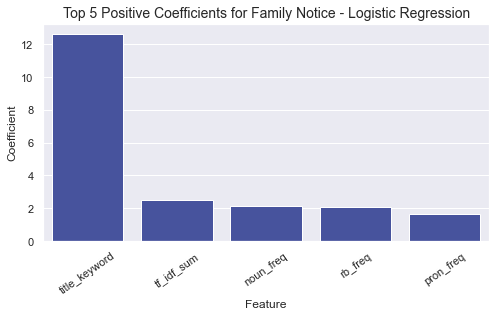

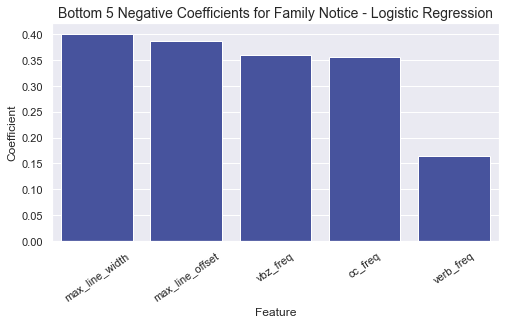

In [16]:
# Visualising the most and least important coefficients
# https://sweetcode.io/easy-scikit-logistic-regression/

coeff_top5 = odds_df.head(5)
coeff_bottom5 = odds_df.tail(5)

# Plot top 5 positive coefficients
sns.set(rc = {'figure.figsize':(8,4)})
plt_1 = sns.barplot(x='feature', y='coef', data = coeff_top5, color = '#3949ab')
plt_1.set_xticklabels(rotation=35, labels=coeff_top5.feature)
plt_1.set_xlabel("Feature", fontsize = 12)
plt_1.set_ylabel("Coefficient", fontsize = 12)
plt_1.set_title("Top 5 Positive Coefficients for Family Notice - Logistic Regression", fontsize = 14)
plt.show()

# Plot bottom 5 negative coefficients
sns.set(rc = {'figure.figsize':(8,4)})
plt_2 = sns.barplot(x='feature', y='coef', data = coeff_bottom5, color = '#3949ab')
plt_2.set_xticklabels(rotation=35, labels=coeff_bottom5.feature)
plt_2.set_xlabel("Feature", fontsize = 12)
plt_2.set_ylabel("Coefficient", fontsize = 12)
plt_2.set_title("Bottom 5 Negative Coefficients for Family Notice - Logistic Regression", fontsize = 14)
plt.show()